<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Adjusting-threshold" data-toc-modified-id="Adjusting-threshold-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Adjusting threshold</a></span><ul class="toc-item"><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Random Forests</a></span></li><li><span><a href="#Load-other-models-and-make-predictions" data-toc-modified-id="Load-other-models-and-make-predictions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load other models and make predictions</a></span></li><li><span><a href="#Adjust-the-decision-the-threshold" data-toc-modified-id="Adjust-the-decision-the-threshold-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Adjust the decision the threshold</a></span><ul class="toc-item"><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Linear regression</a></span></li><li><span><a href="#SVM" data-toc-modified-id="SVM-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#Other" data-toc-modified-id="Other-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Other</a></span></li></ul></li></ul></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></div>

In [2]:
import pdb 
import glob
import copy
import math
import pickle

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
import missingno  # for visualizing missing data
 
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, \
    GridSearchCV, ShuffleSplit

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, \
    LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, \
    precision_score, recall_score, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score, make_scorer,\
    accuracy_score, balanced_accuracy_score

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature


# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 


# Adjust number of CPU cores to use
n_jobs=1

In [60]:
# Load preprocessed training and test set, incl. feature names 
X_train_small = joblib.load('data_processed/X_train_small.joblib')
X_test_small = joblib.load('data_processed/X_test_small.joblib')
y_train_small = joblib.load('data_processed/y_train_small.joblib')
y_test_small = joblib.load('data_processed/y_test_small.joblib')

In [61]:
# Dictionaries to store results for SMALL data set
average_precision_1 = {}
classification_reports_1 = {}
most_important_features_1 = {} 

### Adjusting threshold

#### Random Forests

In [62]:
rf = RandomForestClassifier(n_estimators=100, 
        oob_score=False, n_jobs=n_jobs, random_state=1,
        class_weight='balanced_subsample')
rf.fit(X_train_small, y_train_small)

y_pred_rf_1 = rf.predict(X_test_small) 
y_pred_proba_rf_1 = rf.predict_proba(X_test_small)[:, 1]

# Save results
average_precision_1['random forests'] = \
    average_precision_score(y_test_small, y_pred_proba_rf_1)
classification_reports_1['random forests'] = \
    classification_report(y_test_small, y_pred_rf_1)

In [63]:
average_precision_1

{'random forests': 0.3408734704057727}

#### Load other models and make predictions

In [64]:
# Load models
lr_gs_1 = joblib.load('saved_models/lr_gs_1.joblib')
svm_lin_gs_1 = joblib.load('saved_models/svm_lin_gs_1.joblib')
svm_rbf_gs_1 = joblib.load('saved_models/svm_rbf_gs_1.joblib')
svm_poly_gs_1 = joblib.load('saved_models/svm_poly_gs_1.joblib')

In [65]:
# Predicted probability or distance from separating hyperplane
y_pred_proba_rf = rf.predict_proba(X_test_small)[:, 1]
y_pred_proba_lr_1 = lr_gs_1.predict_proba(X_test_small)[:, 1]
y_pred_distance_svm_lin_1 = svm_lin_gs_1.decision_function(X_test_small)
y_pred_distance_svm_rbf_1 = svm_rbf_gs_1.decision_function(X_test_small)
y_pred_distance_svm_poly_1 = svm_poly_gs_1.decision_function(X_test_small)

#### Adjust the decision the threshold

In [ ]:
# Define function to make a prediction with custom threshold
def custom_prediction(proba_or_dist, threshold):
    """
    Makes predictions for binary classification from probabilities or distance
    to separating hyperplane, given a custom threshold.
    """

    return (proba_or_dist > threshold).astype(int)


# Define function to plot effect of threshold on precision and recall
def plot_threshold(proba_or_dist, y_true, thresholds=None):
    """
    Plot precision and recall as a function of decision threshold for an array of
    probabilities or distances to separating hyperplane.

    If no custom list of thresholds is supplied, it defaults to a grid of length 
    100, spanning between the minimum and maximum probability/distance. (In
    order to avoid thresholds that assign all observations to a single class, 
    the smallest and largest thresholds are offset by 0.01 from the minimum and 
    maximum probability/distance.)

    Parameters
    ----------
    proba_or_dist: array-like
        Probabilities or distance from separating hyperplane
    y_true: array-like
        True values of target variable.
    thresholds: list-like
        Custom thresholds. Optional.  
        
    Returns
    -------
        None
    """
    
    # Initialize dictionaries to store results
    classes = {}
    precisions = {}
    recalls = {}
            
    # If no custom thresholds were passed, make grid between minimum and maximum
    # values for probability or distance.
    if thresholds is None:
        thresholds = np.linspace(proba_or_dist.min() + 0.01,
                                 proba_or_dist.max() - 0.01, 100)

    # Iterate over thresholds
    for threshold in thresholds:
        # Classify as 1 if probability/distance is greater than threshold, else 0
        classes[threshold] = custom_prediction(proba_or_dist, threshold)

        # Compute precision and recall
        precisions[threshold] = precision_score(y_true, classes[threshold])
        recalls[threshold] = recall_score(y_true, classes[threshold])

    # Combine precision and recall into a data frame, indexed by threshold
    pr_rec = pd.DataFrame({'precision': precisions, 'recall': recalls})

    # Plot results
    pr_rec.plot()
    plt.title('Effect of threshold on Precision and Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Precision\nRecall')
    plt.show()

##### Linear regression

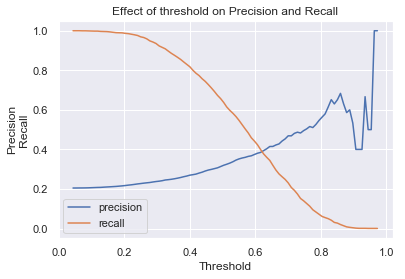

In [66]:
# Plot effect of probability threshold for linear regression
plot_threshold(proba_or_dist=y_pred_proba_lr_1, y_true=y_test_small)

In [67]:
y_lr_custom = custom_prediction(y_pred_proba_lr_1, 0.4)
print(classification_report(y_test_small, y_lr_custom))

              precision    recall  f1-score   support

           0       0.90      0.43      0.58      7953
           1       0.27      0.82      0.41      2047

   micro avg       0.51      0.51      0.51     10000
   macro avg       0.59      0.62      0.49     10000
weighted avg       0.77      0.51      0.55     10000



In [77]:
y_lr_custom = custom_prediction(y_pred_proba_lr_1, 0.4)
def plot_confusion_matrix(y_test, y_pred, digits=3):
    cf = pd.DataFrame(confusion_matrix(y_test, y_pred,
                                      labels=[1,0]),
                      columns=['True', 'False'])
    cf.index=['True', 'False']
    cf.columns.name = 'Predicted'
    cf.index.name = 'Actual'
    print(round(cf / len(y_test), digits))    

# Plot confusion matrix 
plot_confusion_matrix(y_test_small, y_lr_custom)

Predicted   True  False
Actual                 
True       0.167  0.037
False      0.453  0.342


##### SVM

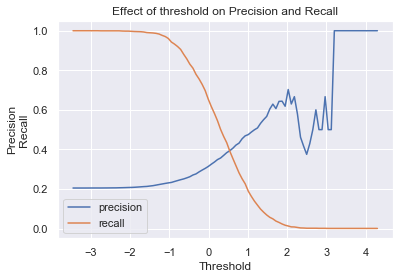

In [69]:
# Plot effect of probability threshold for linear regression
plot_threshold(proba_or_dist=y_pred_distance_svm_lin_1, y_true=y_test_small)

In [70]:
y_svm_lin_custom = custom_prediction(y_pred_distance_svm_lin_1, -0.5)
print(classification_report(y_test_small, y_svm_lin_custom))

              precision    recall  f1-score   support

           0       0.90      0.38      0.54      7953
           1       0.26      0.84      0.40      2047

   micro avg       0.48      0.48      0.48     10000
   macro avg       0.58      0.61      0.47     10000
weighted avg       0.77      0.48      0.51     10000



In [71]:
y_svm_lin_custom = custom_prediction(y_pred_distance_svm_lin_1, -0.4)
def plot_confusion_matrix(y_test, y_pred, digits=3):
    cf = pd.DataFrame(confusion_matrix(y_test, y_pred,
                                      labels=[1,0]),
                      columns=['True', 'False'])
    cf.index=['True', 'False']
    cf.columns.name = 'Predicted'
    cf.index.name = 'Actual'
    print(round(cf / len(y_test), digits))    

# Plot confusion matrix 
plot_confusion_matrix(y_test_small, y_svm_lin_custom)

Predicted   True  False
Actual                 
True       0.166  0.039
False      0.449  0.346


##### Other

In [ ]:
#     def plot_roc(y_test, y_pred, model_name=None):
#         false_positive_rate, true_positive_rate, thresholds = \
#             roc_curve(y_test, y_pred)
#         roc_auc = auc(false_positive_rate, true_positive_rate)
#         plt.plot(false_positive_rate, true_positive_rate, 'b',
#                  label='AUC = {0:.3f}'.format(roc_auc))
#         plt.legend(loc='lower right')
#         plt.plot([0, 1],[0, 1], 'r--')
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         title='ROC Curve'
#         # Add custom title, if specified
#         if model_name is not None:
#             title = ', '.join([title, model_name])
#         plt.title(title)
#         plt.show();

#     # Plot ROC curve for random forests
#     y_pred_proba_rf = rf.predict_proba(X_test_p)[:, 1]
#     plot_roc(y_test, y_pred_proba_rf, 'Random Forests')


#     def plot_precision_recall(y_test, y_pred):
#         """Plots precision-recall curve."""

#         average_precision = average_precision_score(y_test, y_pred)
#         precision, recall, _ = precision_recall_curve(y_test, y_pred)
#         # pdb.set_trace()
#         step_kwargs = ({'step': 'post'}
#                        if 'step' in signature(plt.fill_between).parameters
#                        else {})
#         plt.step(recall, precision, color='b', alpha=0.2,
#                  where='post')
#         plt.figtext(0.2, 0.2, 'Average Precision={0:0.3f}' \
#                                         .format(average_precision))
#         plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

#         plt.xlabel('Recall')
#         plt.ylabel('Precision')
#         plt.ylim([0.0, 1.05])
#         plt.xlim([0.0, 1.0])
#         plt.title('Precision-Recall curve')
#         plt.show();

#     # Plot precision recall curve for random forests classifier
#     plot_precision_recall(y_test, y_pred_proba_rf)

#     # Get a list of feature names
#     cat_names = preprocessor.named_transformers_['cat'] \
#                     .named_steps['onehot'].get_feature_names()
#     feature_names = list(numeric_features) + list(cat_names)
#     # Compute feature importance and sort
#     feature_importances = pd.Series(
#                                 rf.feature_importances_,
#                                 index=feature_names) \
#                             .sort_values(ascending=False)
#     print(feature_importances)

### XGBoost

In [55]:
data_xgb_train = xgb.DMatrix(data=X_train_small, label=y_train_small)
# X_train_small_dmat = xgb.DMatrix(X_train_small)
# X_test_small_dmat = xgb.DMatrix(X_test_small)
# y_train_small_dmat = xgb.DMatrix(y_train_small[:, np.newaxis])
# y_test_small_dmat = xgb.DMatrix(y_test_small)

In [ ]:
# # specify parameters via map
# param = {'objective':'binary:logistic', 'eval_metric':'map',
#          'scale_pos_weight':5  # Balance class weight
#          'seed':0}
# num_round = 2

# train(param, X_train_small, num_round)
# y_pred = xgb_.predict(X_test_small)

In [42]:
X_train_small_dmat.num_col()

119

In [51]:
X_train_small_dmat.num_row()

20000

In [52]:
y_train_small_dmat.num_row()

20000

In [53]:
y_train_small_dmat.num_col()

1

In [57]:
xgb_ = xgb.XGBClassifier(objective='binary:logistic', eval_metric='map',
                         scale_pos_weight=5,  # Balance class weight
                         seed=0, nthread=n_jobs)
# xgb_.fit(X_train_small, y_train_small)

# Parameters to search over
param_grid = {'max_depth'= [3, 5, 7, 10],  # Control complexity
              'min_child_weight'= , # The higher, the more regularization
              'gamma'= , # Higher value leads to fewer splits for a given node (i.e. more regularization) if
              'subsample'= [0.5, 0.75, 1],  # Fraction of observations per tree 
              'colsample_bytree': [0.5, 0.75, 1]} # Fraction of features per tree
# Grid search
xgb_gs_1 = GridSearchCV(xgb_1, param_grid=param_grid, 
                       scoring='average_precision',
                       return_train_score=True,
                       n_jobs=n_jobs, cv=3, verbose=5)
xgb_gs_1.fit(X_train_small, y_train_small) 

# Save model
joblib.dump(xgb_gs_1, 'saved_models/xgb_gs_1.joblib')

# Predictions
y_proba_xgb = xgb_.predict_proba(X_test_small)[:, 1]
average_precision_score(y_test_small, y_proba_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='map', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=5, seed=0, silent=True, subsample=1)

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

In [58]:
params = {'objective':'binary:logistic', 'eval_metric':'map',
         'scale_pos_weight':5,  # Balance class weight
         'seed':0}
xgb_cv = xgb.cv(dtrain=data_xgb_train, params=params, nfold=3,
                num_boost_round=50, as_pandas=True)

[15:15:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[15:15:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[15:15:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[15:15:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[15:15:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:15:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:15:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[15:15:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:15:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[15:15:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[15:15:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[15:15:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:15:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[15:15:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[15:15:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[15:15:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[15:15:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[15:15:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[15:15:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[15:15:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[15:15:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning

In [23]:
y_xgb_cv = xgb_cv.predict(X_test_small)
average_precision_score(y_test_small, y_xgb_cv)

AttributeError: 'DataFrame' object has no attribute 'predict'

In [26]:
xgb_cv

,train-map-mean,train-map-std,test-map-mean,test-map-std
0,0.401211,0.003942,0.319205,0.005456
1,0.437775,0.009257,0.335223,0.004525
2,0.462950,0.008231,0.342017,0.007897
3,0.484441,0.009984,0.344732,0.011293
4,0.504876,0.012760,0.345162,0.015196
5,0.525041,0.006323,0.348258,0.015582
6,0.541862,0.001923,0.350053,0.013862
7,0.558213,0.004790,0.350744,0.014624
8,0.576178,0.004500,0.354275,0.014817
9,0.588563,0.000782,0.354143,0.015086
